<a href="https://www.kaggle.com/code/kapusharinka/spam-detection?scriptVersionId=178814526" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import time
from pprint import pprint
import numpy as np
import pandas as pd

### Articles about ML
https://github.com/christianversloot/machine-learning-articles/tree/main

# Data preprocessing
## Preparing dataset

In [2]:
data = pd.read_csv('/kaggle/input/email-spam-dataset/enronSpamSubset.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    10000 non-null  int64 
 1   Unnamed: 0.1  10000 non-null  int64 
 2   Body          10000 non-null  object
 3   Label         10000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 312.6+ KB


,Unnamed: 0,Unnamed: 0.1,Body,Label
0,2469,2469,Subject: stock promo mover : cwtd\n * * * urge...,1
1,5063,5063,Subject: are you listed in major search engine...,1
2,12564,12564,"Subject: important information thu , 30 jun 20...",1
3,2796,2796,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,1468,1468,"Subject: "" bidstogo "" is places to go , things...",1


In [3]:
# delete unneeded columns
data.drop(["Unnamed: 0","Unnamed: 0.1"],inplace=True,axis=1)

In [4]:
# Remove emails with body longer than 10000
data = data[data['Body'].apply(lambda x: len(str(x)) <= 10000)]

In [5]:
# remove missing values (NaN)
data.dropna(inplace=True)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9882 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    9882 non-null   object
 1   Label   9882 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 231.6+ KB


,Body,Label
0,Subject: stock promo mover : cwtd\n * * * urge...,1
1,Subject: are you listed in major search engine...,1
2,"Subject: important information thu , 30 jun 20...",1
3,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,"Subject: "" bidstogo "" is places to go , things...",1


In [6]:
data.describe(include='object')

,Body
count,9882
unique,9582
top,Subject: \n
freq,16


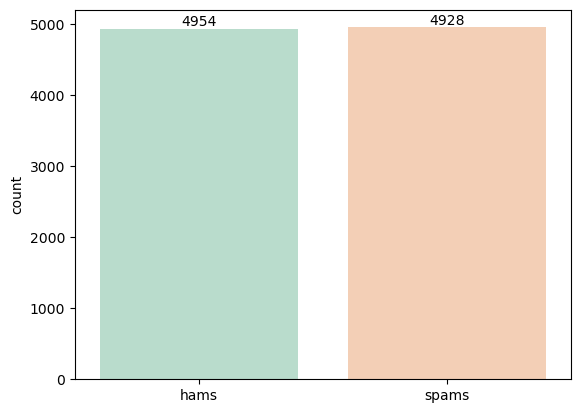

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(x=data["Label"], palette=("Pastel2"))
abs_values = data["Label"].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_xticklabels(['hams', 'spams'])

plt.xlabel(None)
plt.show()

In [8]:
emails = data["Body"]

In [9]:
def max_min_avg_len(email_set):
    max_len, min_len = len(email_set[0]), len(email_set[0])
    avg_len = 0
    for email in email_set:
        if max_len < len(email):
            max_len = len(email)
        if min_len > len(email):
            min_len = len(email)
        avg_len += len(email)
    avg_len = avg_len // len(email_set)
    return f"maximum length: {max_len}, minimum length: {min_len}, average length: {avg_len}"

In [10]:
hams = list(emails[data["Label"] == 1])
spams = list(emails[data["Label"] == 0])

print("All emails:", max_min_avg_len(emails))
print("Ham:", max_min_avg_len(hams))
print("Spam:", max_min_avg_len(spams))

All emails: maximum length: 9998, minimum length: 10, average length: 1253
Ham: maximum length: 9998, minimum length: 10, average length: 1232
Spam: maximum length: 9994, minimum length: 17, average length: 1274


Here I'm removing unneeded characters, like HTML tags, emails etc.

In [11]:
import re

# remove email addresses
emails = [re.sub('\S*@\S*\s?', '', text) for text in emails]
# remove url links
emails = [re.sub('\S*(http[s]?://|www\.)\S*', '', text) for text in emails]
# remove HTML tags
emails = [re.sub(r"'<.*?>'", "", text) for text in emails]
# remove special characters and numbers
emails = [re.sub("[^a-zA-Z]"," ",text) for text in emails]
# remove too short (2- characters) words
emails = [re.sub(r"\b\w{1,2}\b", "",text) for text in emails]
# and too long (17+ characters) 
emails = [re.sub(r"\b\w{17,}\b", "",text) for text in emails]
# remove multiple spaces
emails = [re.sub(' +', ' ', text).strip() for text in emails]
# lower
emails = [text.lower() for text in emails]

emails[0]

'subject stock promo mover cwtd urgent investor trading alert weekly stock pick china world trade corp ticker cwtd breaking news china world trade corp enters into agreement acquire majority stake ceo clubs china limited the ceo clubs tianhe guangzhou china market wire apr china world trade corp otc cwtd news announced today that has entered into agreement acquired majority stake ceo clubs china limited the ceo clubs hong kong corporation with authorized chapter operate under the ceo clubs trademarks the greater china region including the prc hong kong and taiwan china world trade corp symbol cwtd price shares out million market capitalization million significant revenue growth average industry rating strong buy days trading target day trading target cwtd our play the month stock pick here are few simple reasons why one would own china world trade corp china world trade corp announced today that has entered into agreement acquired majority stake ceo clubs china limited the ceo clubs ho

## Tokenization and lemmatization
Tokenization: [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition) (page 180)
<ul>
    <li>one-hot encoding of tokens</li>
    <li>token embedding</li>
</ul>
For more, look at <i>Deep Learning</i> section below.


We can choose between stemming or lemmatization - lemmatizators are slower, but change tenses and nouns. <br/>
https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

At start, I used NLTK lemmatization, but it is very slow on my computer, so I tried SpaCy instead (https://spacy.io).

In [12]:
custom_stopwords = ['subject', 'empty', 'email', 'mail', 'enron', 'linux', 'list', 'get', 'http', 'vince', 'com', 'org', 'www', 'etc', 'ect', 'edu', 'hou', 'would', 'need']

### Using SpaCy
https://stackoverflow.com/a/75215495

In [13]:
import spacy

nlp = spacy.load("en_core_web_sm")

# add stop words
for word in custom_stopwords:
    nlp.vocab[word].is_stop = True

In [14]:
# lemmatization
emails = [[token.lemma_ for token in nlp(text) if not token.is_stop] for text in emails]
emails[0][:15]

['stock',
 'promo',
 'mover',
 'cwtd',
 'urgent',
 'investor',
 'trading',
 'alert',
 'weekly',
 'stock',
 'pick',
 'china',
 'world',
 'trade',
 'corp']

## Feature extraction 
Creating a vector of features (words) for each email. <br />
OpenAI:
> Both CountVectorizer and TF-IDF (Term Frequency-Inverse Document Frequency) from scikit-learn are popular techniques for feature extraction in text data like emails, and each has its own merits.
> 
> CountVectorizer creates a Bag of Words (BoW) model, where the features are the counts of each word in the document. This method is simple and easy to implement but can give more importance to words that appear frequently, regardless of their significance in distinguishing spam from non-spam emails.
> 
> TF-IDF, on the other hand, takes into account not only the frequency of a word in a document but also its inverse frequency across all documents. This means that words that are common across all emails will receive lower weights, while words that are unique to specific emails will receive higher weights. This can be advantageous for spam detection, as spam emails often contain specific words or phrases that are less common in legitimate emails.
> 
> In general, TF-IDF tends to work better than CountVectorizer for spam detection because it can better capture the importance of different words. However, the choice between the two methods will depend on the specific characteristics of the dataset and the problem you're trying to solve. It's a good idea to experiment with both techniques and evaluate their performance on your dataset using cross-validation or a separate validation set. This will help you determine which method works best for your particular spam detection task.

In [15]:
# bag of words
from sklearn.feature_extraction.text import CountVectorizer

# ngram_range=(1,2) means that the model will consider bigrams too
# min_df=0.003 means that the model will not consider rare words
count_vectorizer = CountVectorizer(max_features=25000, ngram_range=(1,5), min_df=0.003, max_df=0.9)
bag_of_words = count_vectorizer.fit_transform([" ".join(text) for text in emails]).toarray()
print(bag_of_words.shape)
count_vectorizer.get_feature_names_out()[:10] # first 10 in alphabetical order

(9882, 6613)


array(['abiiity', 'ability', 'able', 'abroad', 'absence', 'absolute',
       'absolutely', 'abuse', 'abuse program', 'academic'], dtype=object)

In [16]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vectorizer = TfidfVectorizer(max_features=25000, ngram_range=(1,5), min_df=0.003, max_df=0.9)
tf_idf = tf_vectorizer.fit_transform([" ".join(text) for text in emails]).toarray()
print(tf_idf.shape)
tf_vectorizer.get_feature_names_out()[:10]

(9882, 6613)


array(['abiiity', 'ability', 'able', 'abroad', 'absence', 'absolute',
       'absolutely', 'abuse', 'abuse program', 'academic'], dtype=object)

## Word embeddings
A word embedding is a vector, that tries to capture "meaning" of a word/sentence/document etc... Some of the algorithms are provided by Word2Vec, GloVe. I used one provided by SpaCy.

### Using SpaCy
Also check [sense2vec](http://https://github.com/explosion/sense2vec)

In [17]:
nlp = spacy.blank("en")
nlp.from_disk('/kaggle/input/en-core-web-lg/en_core_web_lg/en_core_web_lg-3.6.0')

Creating vectors for each email. We take a vector for each word from email, and finding the average vector for a whole email.

In [18]:
email_embeddings = []
for email in emails:
    if len(email) > 0:
        spacy_doc = nlp(' '.join(email))
        avg_vector = sum([token.vector for token in spacy_doc]) / len(email)
    else:
        avg_vector = nlp('').vector
    email_embeddings.append(avg_vector)

## Word cloud
Here are word clouds for spams and hams with the most frequent words, created with TF-IDF vectorizer.

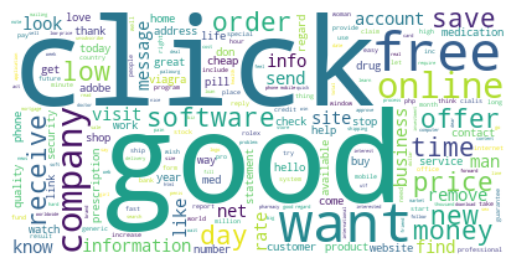

In [19]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

data['Tokens'] = emails

# spams
spams = data.loc[data['Label'] == 1, ['Tokens']]
spam_x = tf_vectorizer.fit_transform([" ".join(text) for text in spams['Tokens']]).toarray()

df = pd.DataFrame(spam_x.tolist(), columns=tf_vectorizer.get_feature_names_out())
df.head(10)

wordcloud = WordCloud(background_color='white', max_words=200,
                      stopwords = STOPWORDS, collocations=True).generate_from_frequencies(df.T.sum(axis=1))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

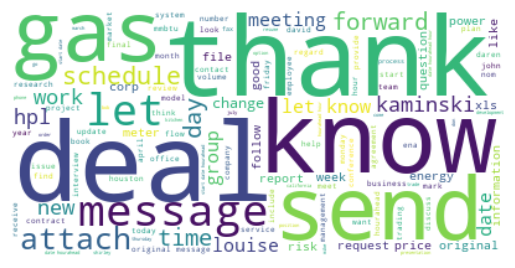

In [20]:
# hams
hams = data.loc[data['Label'] == 0, ['Tokens']]
ham_x = tf_vectorizer.fit_transform([" ".join(text) for text in hams['Tokens']]).toarray()

df = pd.DataFrame(ham_x.tolist(), columns=tf_vectorizer.get_feature_names_out())

wordcloud = WordCloud(background_color='white', max_words=200,
                      stopwords = STOPWORDS, collocations=True).generate_from_frequencies(df.T.sum(axis=1))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Scaling
No need for scaling for word embeddings.

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

bag_of_words = scaler.fit_transform(bag_of_words)
tf_idf = scaler.fit_transform(tf_idf)

## PCA
Sometimes PCA can improve the scores.

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
bag_of_words_pca = pca.fit_transform(bag_of_words)
tf_idf_pca = pca.fit_transform(tf_idf)
email_embeddings_pca = pca.fit_transform(email_embeddings)

## Split to train and test data
Our dataset is roughly balanced, and it's good for training supervised models. But in real world, the dataset is often very unbalanced. So let's create an unbalanced dataset with 5% of anomalies.

In [23]:
def shuffle_data(features, labels):
    indices = np.arange(features.shape[0])
    np.random.shuffle(indices)
    return features[indices], labels[indices]

def unbalanced_dataset(dataset): 
    labels = np.asarray(data["Label"])
    
    normal = dataset[labels == 0]
    anomalies = dataset[labels == 1]

    # select random 5% of anomalies
    num_anomalies = int(len(normal) * 0.05)
    anomaly_indices = np.random.choice(anomalies.shape[0], num_anomalies, replace=False)
    selected_anomalies = anomalies[anomaly_indices]
    
    # combine
    X_unbalanced = np.vstack([normal, selected_anomalies])
    y_unbalanced = np.concatenate([np.full((len(normal)), 1), np.full((len(selected_anomalies)), 0)])

    # shuffle
    X_unbalanced, y_unbalanced = shuffle_data(X_unbalanced, y_unbalanced)
    return X_unbalanced, y_unbalanced

In [24]:
labels = np.asarray(data["Label"])

sets = [
    [bag_of_words, labels, "Bag of words (balanced)"],
    [tf_idf, labels, "TF-IDF (balanced)"],
    [np.array(email_embeddings), labels, "Word embeddings (balanced)"],
    list(unbalanced_dataset(bag_of_words)) + ["Bag of words (unbalanced)"],
    list(unbalanced_dataset(tf_idf)) + ["TF-IDF (unbalanced)"],
    list(unbalanced_dataset(np.array(email_embeddings))) + ["Word embeddings (unbalanced)"],
    list(unbalanced_dataset(bag_of_words_pca)) + ["Bag of words (unbalanced) + PCA"],
    list(unbalanced_dataset(tf_idf_pca)) + ["TF-IDF (unbalanced) + PCA"],
    list(unbalanced_dataset(email_embeddings_pca)) + ["Word embeddings (unbalanced) + PCA"],
]

In [25]:
# scores for cross-validation

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1_score': make_scorer(f1_score, average='binary')
}

def display_results(metrics):
    metrics["Metric"] = ["Fit Time", "Accuracy", "Precision", "Recall", "F1 Score"]
    df_metrics = pd.DataFrame(metrics)
    df_metrics.set_index("Metric", inplace=True)
    return df_metrics.T

def train_test_sup_model(model, linear_svc=False):
    all_results = {}

    for curr_set in sets:
        X, y, name = curr_set[0], curr_set[1], curr_set[2]

        results = cross_validate(model, 
                                 X if not linear_svc else MinMaxScaler().fit_transform(X), 
                                 y, cv=5, scoring=scoring, return_train_score = False)
        all_results[name] = [results[score_name].mean() for score_name in results if score_name != "score_time"]

    return display_results(all_results)

# Classification algorithms (supervised learning)
https://towardsdatascience.com/top-10-binary-classification-algorithms-a-beginners-guide-feeacbd7a3e2 <br />
As we can see, the worse results are given by Naive Bayes with CountVectorizer. Other algorithms are dealing more or less well. The best results are given by VotingClassifier. <br />
We see that embeddings indeed performs better.
## Evaluation metrics:
**Accuracy** = (True Positives + True Negatives) / (True Positives + False Positives + True Negatives + False Negatives) <br />
Accuracy measures the proportion of correct predictions made by the model out of the total number of predictions.


**Precision** = True Positives / (True Positives + False Positives) <br />
Precision measures the proportion of true positive predictions out of all the positive predictions made by the model.


**Recall** = True Positives / (True Positives + False Negatives) <br />
Recall measures the proportion of true positive predictions to the number of actual positives (true positives + false negatives).


**F1 Score** = 2 * (Precision * Recall) / (Precision + Recall) <br />
An F1 score reaches its best value at 1 (perfect precision and recall) and its worst value at 0.

The algorithms are run three times: on bag of words, TF-IDF and word embeddings
## Gaussian Naive Bayes

In [26]:
from sklearn.naive_bayes import GaussianNB

GB = GaussianNB()
train_test_sup_model(GB)

Metric,Fit Time,Accuracy,Precision,Recall,F1 Score
Bag of words (balanced),0.921734,0.864906,0.975858,0.749089,0.847518
TF-IDF (balanced),0.913877,0.890507,0.970842,0.805810,0.880602
Word embeddings (balanced),0.018218,0.805809,0.842948,0.753333,0.795513
Bag of words (unbalanced),0.484497,0.974488,0.975423,0.998377,0.986765
TF-IDF (unbalanced),0.482301,0.971008,0.976102,0.993913,0.984920
Word embeddings (unbalanced),0.010878,0.906456,0.985767,0.914975,0.949042
Bag of words (unbalanced) + PCA,0.108415,0.825688,0.964414,0.848648,0.898811
TF-IDF (unbalanced) + PCA,0.164103,0.933900,0.966623,0.963878,0.965248
Word embeddings (unbalanced) + PCA,0.009773,0.948977,0.968742,0.978091,0.973248


## Logistic regression

In [27]:
from sklearn.linear_model import LogisticRegression

# lbfgs is the fastest
# for solver in ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']:
#     print(solver)
#     LR = LogisticRegression(max_iter=1000, solver=solver)

#     for curr_set in sets:
#         X, y = curr_set[0], curr_set[1]

#         results = cross_validate(LR, X, y, cv=5, scoring=scoring, return_train_score = False)
#         display_results(results)
        
LR = LogisticRegression(max_iter=1000, solver='lbfgs')
train_test_sup_model(LR)

Metric,Fit Time,Accuracy,Precision,Recall,F1 Score
Bag of words (balanced),6.949947,0.965695,0.960207,0.971942,0.965999
TF-IDF (balanced),4.292146,0.974904,0.971984,0.978199,0.975059
Word embeddings (balanced),1.580358,0.952641,0.947552,0.958620,0.953044
Bag of words (unbalanced),2.988102,0.975842,0.978874,0.996145,0.987429
TF-IDF (unbalanced),1.536830,0.975840,0.976419,0.998783,0.987467
Word embeddings (unbalanced),0.513817,0.972362,0.985005,0.985998,0.985497
Bag of words (unbalanced) + PCA,0.797322,0.972362,0.979970,0.991275,0.985581
TF-IDF (unbalanced) + PCA,0.692914,0.979126,0.979132,0.999391,0.989156
Word embeddings (unbalanced) + PCA,0.156450,0.971202,0.984793,0.984985,0.984882


## *k*-nearest neighbors

In [28]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()
train_test_sup_model(KNN)

Metric,Fit Time,Accuracy,Precision,Recall,F1 Score
Bag of words (balanced),0.193315,0.816534,0.741877,0.972547,0.841677
TF-IDF (balanced),0.193830,0.616070,0.566442,0.998385,0.722793
Word embeddings (balanced),0.005756,0.934325,0.926725,0.943683,0.935096
Bag of words (unbalanced),0.101823,0.928481,0.966809,0.958175,0.961722
TF-IDF (unbalanced),0.100111,0.954581,0.954486,1.000000,0.976712
Word embeddings (unbalanced),0.003524,0.969849,0.972493,0.996551,0.984367
Bag of words (unbalanced) + PCA,0.023655,0.958252,0.958191,0.999797,0.978551
TF-IDF (unbalanced) + PCA,0.031191,0.955547,0.955412,1.000000,0.977197
Word embeddings (unbalanced) + PCA,0.002905,0.967338,0.971860,0.994522,0.983055


## Linear support vector

In [29]:
# very long
from sklearn.svm import LinearSVC

SVC = LinearSVC(max_iter = 8000)
train_test_sup_model(SVC, linear_svc=True)

## Decision tree

In [30]:
from sklearn.tree import DecisionTreeClassifier

# 'entropy' is the fastest
# for criterion in ['gini', 'entropy', 'log_loss']:
#     print(criterion)
#     DTC = DecisionTreeClassifier(criterion=criterion)

#     for curr_set in sets:
#         X, y = curr_set[0], curr_set[1]

#         results = cross_validate(DTC, X, y, cv=5, scoring=scoring, return_train_score = False)
#         display_results(results)
        
DTC = DecisionTreeClassifier(criterion='entropy')
train_test_sup_model(DTC)

Metric,Fit Time,Accuracy,Precision,Recall,F1 Score
Bag of words (balanced),12.458447,0.913176,0.914050,0.912599,0.913307
TF-IDF (balanced),15.552237,0.912974,0.910986,0.916028,0.913466
Word embeddings (balanced),3.202149,0.864703,0.862674,0.868391,0.865505
Bag of words (unbalanced),9.151387,0.947235,0.976905,0.967528,0.972147
TF-IDF (unbalanced),12.593765,0.956899,0.975349,0.979504,0.977421
Word embeddings (unbalanced),1.031316,0.942791,0.970365,0.969560,0.969951
Bag of words (unbalanced) + PCA,6.535181,0.960958,0.979701,0.979303,0.979500
TF-IDF (unbalanced) + PCA,10.900379,0.961154,0.978921,0.980317,0.979613
Word embeddings (unbalanced) + PCA,0.506841,0.944529,0.972333,0.969359,0.970836


## Random forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

# 5 is the fastest, with the same results
# for n_estimators in [5, 10, 15, 25, 50, 100]:
#     print(n_estimators)
#     RFC = RandomForestClassifier(n_estimators=n_estimators)

#     for curr_set in sets:
#         X, y = curr_set[0], curr_set[1]

#         results = cross_validate(RFC, X, y, cv=5, scoring=scoring, return_train_score = False)
#         display_results(results)
        
RFC = RandomForestClassifier(n_estimators=5)
train_test_sup_model(RFC)

Metric,Fit Time,Accuracy,Precision,Recall,F1 Score
Bag of words (balanced),1.187342,0.942826,0.943620,0.942272,0.942927
TF-IDF (balanced),1.318881,0.944140,0.943462,0.945299,0.944309
Word embeddings (balanced),0.592710,0.898097,0.892991,0.905329,0.899065
Bag of words (unbalanced),0.893369,0.971588,0.977274,0.993303,0.985205
TF-IDF (unbalanced),0.994680,0.972168,0.974235,0.997159,0.985560
Word embeddings (unbalanced),0.300202,0.957866,0.963765,0.993101,0.978212
Bag of words (unbalanced) + PCA,0.947396,0.958253,0.961068,0.996551,0.978484
TF-IDF (unbalanced) + PCA,1.751056,0.965597,0.968826,0.995942,0.982190
Word embeddings (unbalanced) + PCA,0.232566,0.949942,0.957481,0.991477,0.974181


## Voting classifier

In [32]:
from sklearn.ensemble import VotingClassifier

VC = VotingClassifier(estimators=[('LR',LR),('RFC',RFC)], voting='hard')
train_test_sup_model(VC)   

Metric,Fit Time,Accuracy,Precision,Recall,F1 Score
Bag of words (balanced),7.921879,0.950618,0.979424,0.920872,0.949207
TF-IDF (balanced),5.200888,0.958005,0.985054,0.930360,0.956914
Word embeddings (balanced),2.213130,0.926331,0.971855,0.878481,0.922799
Bag of words (unbalanced),3.429128,0.972169,0.983853,0.987012,0.985412
TF-IDF (unbalanced),2.475656,0.977193,0.980242,0.996145,0.988126
Word embeddings (unbalanced),0.980972,0.969077,0.985746,0.981738,0.983732
Bag of words (unbalanced) + PCA,1.773373,0.970622,0.980891,0.988434,0.984642
TF-IDF (unbalanced) + PCA,2.447849,0.978739,0.982384,0.995536,0.988915
Word embeddings (unbalanced) + PCA,0.434907,0.967336,0.985325,0.980317,0.982807


# Unsupervised algorithms 

We can't use cross_validate function for unsupervised algorithms, so let's create 5 different sets manually. For One-class SVM, Local Outlier Factor, K-Means and Gaussian Mixture model, our train sets will consist only from normal data. For Isolation Forest, we will create separate train models with anomalies.

In [33]:
from sklearn.model_selection import KFold

def create_cross_validation_sets(dataset, labels):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    X_trains, X_tests, y_trains, y_tests = [], [], [], []

    for train_index, test_index in kf.split(dataset):
        X_trains.append(dataset[train_index])
        X_tests.append(dataset[test_index])
        y_trains.append(labels[train_index])
        y_tests.append(labels[test_index])

    # For algorithms (except Isolation Forest) remove anomalies from train sets
    X_trains_normal = []

    for X_train, y_train in zip(X_trains, y_trains):
        X_trains_normal.append(X_train[y_train == 1]) 
        
    return X_trains_normal, X_trains, X_tests, y_trains, y_tests

In [34]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score
from scipy.spatial.distance import cdist
import time

def is_balanced(labels):
    # returns the sorted unique elements of an array
    values, counts = np.unique(labels, return_counts=True)
    return counts[1] / counts[0] < 5

def gaussian_mixture_model_predictions(model, X_test, y_test):
    scores = model.score_samples(X_test)
    threshold = np.percentile(scores, 50 if is_balanced(y_test) else 5)
    return np.array([0 if score < threshold else 1 for score in scores]) 

def kmeans_predictions(model, X_test, y_test):
    labels = model.predict(X_test)
    centroids = model.cluster_centers_
    distances = cdist(X_test, centroids, 'euclidean')
    min_distances = distances[np.arange(len(distances)), labels]
    threshold = np.percentile(min_distances, 50 if is_balanced(y_test) else 5)
    return np.array([0 if d > threshold else 1 for d in min_distances])

def train_test_model(model, current_set, labels, 
                     novelty=True, gaussian_mixture_model=False, kmeans=False):
    
    X_trains_normal, X_trains, X_tests, y_trains, y_tests = create_cross_validation_sets(current_set, labels)
    
    fit_time_total, accuracy_total, precision_total, recall_total, f1score_total = 0, 0, 0, 0, 0
    pred = []

    for X_train, X_test, y_test in zip(
        X_trains_normal if novelty else X_trains, 
        X_tests, 
        y_tests if novelty else y_trains):
        
        if novelty: 
            start_time = time.time()
            model.fit(X_train)
            fit_time_total += time.time() - start_time

            if gaussian_mixture_model:
                pred = gaussian_mixture_model_predictions(model, X_test, y_test) 
            elif kmeans:
                pred = kmeans_predictions(model, X_test, y_test)
            else:
                pred = np.array([1 if p == -1 else 0 for p in model.predict(X_test)])
        
        else:
            start_time = time.time()
            pred = np.array([1 if p == -1 else 0 for p in model.fit_predict(X_train)])
            fit_time_total += time.time() - start_time

        accuracy_total += balanced_accuracy_score(y_test, pred)
        precision_total += precision_score(y_test, pred)
        recall_total += recall_score(y_test, pred)
        f1score_total += f1_score(y_test, pred)
    
    return [fit_time_total / len(X_trains_normal), accuracy_total / len(X_trains_normal), precision_total / len(X_trains_normal), 
                  recall_total / len(X_trains_normal), f1score_total / len(X_trains_normal)]
    
def train_test_unsup_model(model, novelty=True, gaussian_mixture_model=False, kmeans=False):
    all_results = {}

    for curr_set in sets:
        X, y, name = curr_set[0], curr_set[1], curr_set[2]
        all_results[name] = train_test_model(model, X, y, novelty, gaussian_mixture_model, kmeans)

    return display_results(all_results)

## One-class SVM
Each entry is either 1 for normal data or -1 for an anomaly. <br/>
One-class SVM is trained on the normal data only, and tested on test set.

In [47]:
# very long
from sklearn.svm import OneClassSVM

# 'sigmoid' and nu = 0.2 give better results and are faster
# for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
#     for nu in [0.2, 0.5, 0.7]:
#         print(kernel, nu)
#         model = OneClassSVM(kernel = kernel, nu = nu)

#         for curr_set in sets:
#             X, y = curr_set[0], curr_set[1]
#             train_test_model(model, X, y)

model = OneClassSVM(kernel = 'sigmoid', nu = 0.5)
train_test_unsup_model(model)

Metric,Fit Time,Accuracy,Precision,Recall,F1 Score
Bag of words (balanced),63.148396,0.277125,0.356841,0.549628,0.432550
TF-IDF (balanced),64.205567,0.289898,0.367533,0.575763,0.448452
Word embeddings (balanced),2.677013,0.456383,0.461222,0.501173,0.480263
Bag of words (unbalanced),62.615198,0.278100,0.917582,0.556199,0.692444
TF-IDF (unbalanced),62.435878,0.284385,0.919195,0.568770,0.702439
Word embeddings (unbalanced),2.622013,0.472930,0.947142,0.496729,0.651523
Bag of words (unbalanced) + PCA,16.540272,0.265184,0.913619,0.530368,0.670865
TF-IDF (unbalanced) + PCA,23.779442,0.269286,0.915208,0.538571,0.677890
Word embeddings (unbalanced) + PCA,1.580105,0.262518,0.911544,0.503663,0.648760


## Local Outlier Factor
Local outlier factor can be used in two ways: build a new model for the whole dataset each time, or fit it on the normal data only, and predict it on different sets.

In [36]:
# outlier detection
from sklearn.neighbors import LocalOutlierFactor

# 10 is the best
# for n_neighbors in [3, 5, 10, 15, 20, 25]:
#     print(n_neighbors)
#     model = LocalOutlierFactor(n_neighbors=n_neighbors)

#     for curr_set in sets:
#         X, y = curr_set[0], curr_set[1]
#         train_test_model(model, X, y, novelty=False)

model = LocalOutlierFactor(n_neighbors=10)
train_test_unsup_model(model, novelty=False)

Metric,Fit Time,Accuracy,Precision,Recall,F1 Score
Bag of words (balanced),8.625770,0.428596,0.457662,0.746681,0.567484
TF-IDF (balanced),8.229042,0.453989,0.473914,0.793820,0.593500
Word embeddings (balanced),2.019356,0.494169,0.489662,0.245828,0.327285
Bag of words (unbalanced),2.479869,0.450542,0.947400,0.882709,0.913910
TF-IDF (unbalanced),2.312913,0.397707,0.940701,0.778113,0.851699
Word embeddings (unbalanced),0.520899,0.484808,0.945482,0.197242,0.326365
Bag of words (unbalanced) + PCA,0.953831,0.436866,0.945953,0.873732,0.908398
TF-IDF (unbalanced) + PCA,1.294945,0.425268,0.943108,0.716085,0.813833
Word embeddings (unbalanced) + PCA,0.450562,0.475072,0.939635,0.172688,0.291735


In [37]:
# novelty detection
# for n_neighbors in [3, 5, 10, 15, 20, 25]:
#     print(n_neighbors)
#     model = LocalOutlierFactor(n_neighbors=n_neighbors, novelty=True)

#     for curr_set in sets:
#         X, y = curr_set[0], curr_set[1]
#         train_test_model(model, X, y)

model = LocalOutlierFactor(n_neighbors=10, novelty=True)
train_test_unsup_model(model)

Metric,Fit Time,Accuracy,Precision,Recall,F1 Score
Bag of words (balanced),2.337900,0.374311,0.429357,0.748002,0.545433
TF-IDF (balanced),2.343141,0.397167,0.443947,0.793714,0.569272
Word embeddings (balanced),0.515629,0.241672,0.252127,0.261095,0.256267
Bag of words (unbalanced),2.354496,0.455838,0.947920,0.886368,0.916088
TF-IDF (unbalanced),2.288250,0.395775,0.940611,0.779707,0.852417
Word embeddings (unbalanced),0.473757,0.398443,0.907670,0.194793,0.320678
Bag of words (unbalanced) + PCA,1.034445,0.439725,0.946262,0.875605,0.909542
TF-IDF (unbalanced) + PCA,1.116142,0.407011,0.940518,0.698579,0.801509
Word embeddings (unbalanced) + PCA,0.415199,0.404075,0.905216,0.172275,0.289378


## Isolation Forest

In [38]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=20)
train_test_unsup_model(model)
# sometimes, the precision, recall and f1-score are 0. It probably means that the model predicted everything as normal

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

Metric,Fit Time,Accuracy,Precision,Recall,F1 Score
Bag of words (balanced),3.696188,0.510812,1.000000,0.021623,0.042264
TF-IDF (balanced),3.713741,0.506743,0.800000,0.013486,0.026502
Word embeddings (balanced),0.115369,0.498600,0.488215,0.061606,0.109069
Bag of words (unbalanced),3.808513,0.498347,0.200000,0.000202,0.000403
TF-IDF (unbalanced),3.779593,0.500000,0.000000,0.000000,0.000000
Word embeddings (unbalanced),0.107424,0.481315,0.926618,0.067733,0.125121
Bag of words (unbalanced) + PCA,1.172503,0.499370,0.951378,0.044467,0.084532
TF-IDF (unbalanced) + PCA,1.453310,0.493983,0.932611,0.023953,0.046602
Word embeddings (unbalanced) + PCA,0.089720,0.500037,0.955133,0.059866,0.112626


## Gaussian Mixture Model
https://vitalflux.com/gaussian-mixture-models-what-are-they-when-to-use/ <br/>
https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4 (also determining appropriate number of clusters)<br/>
https://github.com/vlavorini/ClusterCardinality/blob/master/Cluster%20Cardinality.ipynb<br/>
https://stackoverflow.com/questions/26079881/kl-divergence-of-two-gmms<br/>
https://stats.stackexchange.com/questions/349258/correct-number-of-components-in-gmm-according-to-bic-and-aic-plots<br/>
https://stats.stackexchange.com/questions/368560/elbow-test-using-aic-bic-for-identifying-number-of-clusters-using-gmm<br/>
https://grabngoinfo.com/how-to-decide-the-number-of-clusters-data-science-interview-questions-and-answers/
Bayesian Information Criterion (BIC) or Akaike Information Criterion (AIC) scores

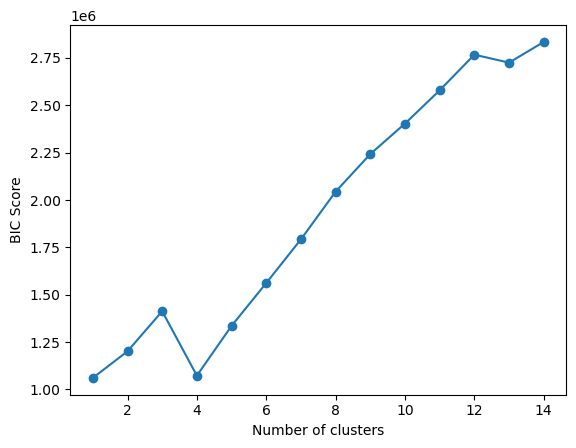

In [39]:
from sklearn.mixture import GaussianMixture

normal_dataset = np.array(email_embeddings)[labels == 0]

n_clusters = range(1, 15)
bics = []
for k in n_clusters:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(normal_dataset)
    bics.append(gmm.bic(normal_dataset))

plt.plot(n_clusters, bics, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('BIC Score')
plt.show()

In [40]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=4, covariance_type='spherical', random_state=42)
train_test_unsup_model(model, gaussian_mixture_model=True)

Metric,Fit Time,Accuracy,Precision,Recall,F1 Score
Bag of words (balanced),7.483294,0.540207,0.541480,0.540247,0.540739
TF-IDF (balanced),2.709094,0.485305,0.486640,0.485340,0.485878
Word embeddings (balanced),1.018425,0.549528,0.550785,0.549661,0.550095
Bag of words (unbalanced),4.584130,0.538497,0.956249,0.953540,0.954886
TF-IDF (unbalanced),12.427736,0.584874,0.960114,0.957371,0.958728
Word embeddings (unbalanced),0.786658,0.517831,0.954213,0.951505,0.952854
Bag of words (unbalanced) + PCA,1.634962,0.551158,0.957265,0.954545,0.955897
TF-IDF (unbalanced) + PCA,1.560343,0.557865,0.957878,0.955155,0.956504
Word embeddings (unbalanced) + PCA,0.366705,0.516218,0.954009,0.951299,0.952650


## K-Means
https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html#sphx-glr-auto-examples-cluster-plot-mini-batch-kmeans-py <br />
https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/ <br />
https://stackoverflow.com/a/69024239 <br/>
https://stackoverflow.com/a/27586132 <br />
https://www.dataknowsall.com/textclustering.html <br />
https://www.kaggle.com/code/naren3256/kmeans-clustering-and-cluster-visualization-in-3d/notebook <br />
https://medium.com/@jwbtmf/visualizing-data-using-k-means-clustering-unsupervised-machine-learning-8b59eabfcd3d <br />
For choosing the appropriate number of clusters, we can use Elbow method or Silhouette score. Let's use Elbow method.

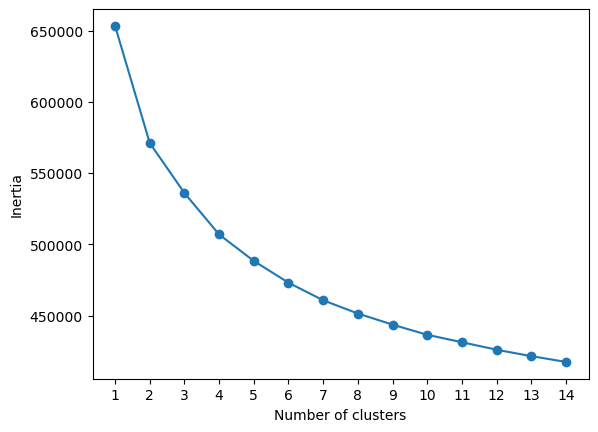

In [41]:
# finding the optimal number of clusters using an elbow method
from sklearn.cluster import KMeans

n_clusters = range(1, 15)
inertias = []
for k in n_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(normal_dataset)
    inertias.append(kmeans.inertia_)

plt.plot(n_clusters, inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(n_clusters)
plt.show()

In [42]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

model = KMeans(n_clusters=9)
train_test_unsup_model(model, kmeans=True)

Metric,Fit Time,Accuracy,Precision,Recall,F1 Score
Bag of words (balanced),7.058301,0.547703,0.548968,0.547761,0.548238
TF-IDF (balanced),7.776203,0.497050,0.498375,0.497027,0.497588
Word embeddings (balanced),2.299324,0.591862,0.593075,0.591767,0.592285
Bag of words (unbalanced),8.582885,0.504087,0.961538,0.050736,0.096385
TF-IDF (unbalanced),11.636938,0.526381,1.000000,0.052762,0.100236
Word embeddings (unbalanced),2.268025,0.520617,0.988534,0.052352,0.099438
Bag of words (unbalanced) + PCA,3.144965,0.522030,0.992308,0.052558,0.099828
TF-IDF (unbalanced) + PCA,5.202857,0.512375,0.973077,0.051336,0.097527
Word embeddings (unbalanced) + PCA,1.436492,0.522472,0.992308,0.052352,0.099458


# Deep learning (unsupervised)
(subset of machine learning algorithms)<br/>
[Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition)

## Autoencoder
https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798

In [43]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Sequential, Model

X, y = sets[2][0], sets[2][1]

X_trains_normal, _, X_tests, _, y_tests = create_cross_validation_sets(X, y)
X_train_normal, X_test, y_test = X_trains_normal[0], X_tests[0], y_tests[0]

# Input layer
input = Input(shape=(X_train_normal.shape[1],))

# Encoder layers
encoder = Sequential([
    Dense(256, activation='relu'),  
    Dense(64, activation='relu'),  
    Dense(16, activation='relu'),
    Dense(4, activation='relu')])(input)

# Decoder layers
decoder = Sequential([
    Dense(16, activation='relu'),
    Dense(64, activation='relu'),
    Dense(256, activation='relu'),
    Dense(X_train_normal.shape[1], activation="sigmoid")])(encoder)

# Create the autoencoder
autoencoder = Model(inputs=input, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(X_train_normal, X_train_normal, 
                          epochs=10, 
                          batch_size=256,
                          validation_split=0.2,
                          shuffle=True)

reconstructed_test = autoencoder.predict(X_test)

# Calculate the mean squared error of the reconstruction
mse_test = np.mean(np.power(X_test - reconstructed_test, 2), axis=1)

# Determine a threshold for classifying a point as an anomaly
threshold = np.percentile(mse_test, 95)  # Set threshold at the 95th percentile

# Anything above the threshold is considered an anomaly
pred = (mse_test > threshold).astype(int)

print(f"accuracy: {balanced_accuracy_score(y_test, pred)}")
print(f"precision: {precision_score(y_test, pred)}")
print(f"recall: {recall_score(y_test, pred)}")
print(f"f1-score: {f1_score(y_test, pred)}")

Epoch 1/10
13/13 [==============================] - 2s 31ms/step - loss: 1.5206 - val_loss: 1.1219
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 1.0901 - val_loss: 1.0789
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 1.0805 - val_loss: 1.0762
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 1.0785 - val_loss: 1.0744
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 1.0769 - val_loss: 1.0723
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 1.0735 - val_loss: 1.0671
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 1.0688 - val_loss: 1.0620
Epoch 8/10
13/13 [==============================] - 0s 12ms/step - loss: 1.0649 - val_loss: 1.0584
Epoch 9/10
13/13 [==============================] - 0s 12ms/step - loss: 1.0617 - val_loss: 1.0561
Epoch 10/10
62/62 [==============================] - 0s 2ms/step
accuracy: 0.5171233367451382
precision: 0.67